# Audio signal pre-processing

Audio signal data will be converted into time domain features and frequency domain features

In [1]:
import os
import math
import librosa
import numpy as np

In [2]:
DATASET_PATH = "datasets/final_audio"
SAMPLE_RATE = 22050
TRACK_DURATION = 30  # seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

MFCC_NUM = 13
FFT_NUM = 2048
HOP_LENGTH = 512
SEGMENTS_NUM = 5

category_labelling_map = {
  "ambulance": 0,
  "police": 1,
  "fire-and-trucks": 2,
}

# Time domain feature extraction

In [3]:
time_domain_features = {
  "category": [],
  "labels": [],
  "data": []
}

for i, f in enumerate(os.listdir(DATASET_PATH)):
  file_path = os.path.join(DATASET_PATH, f)
  signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

  # number of segments based on duration
  num_segments = int(len(signal) / SAMPLES_PER_TRACK) + 1

  category = f.split("_")[0]
  time_domain_features["category"].append(category)
  time_domain_features["labels"].append(category_labelling_map[category])
  time_domain_features["data"].append(signal)

## Mel-Spectogram feature extraction on each frame of audio chunks

In [5]:
spect_features = {
  "category": [],
  "labels": [],
  "spectogram": []
}

# todo: reuse `time_domain_features` variable

samples_per_segment = int(SAMPLES_PER_TRACK / SEGMENTS_NUM)
num_spect_vectors_per_segment = math.ceil(samples_per_segment / HOP_LENGTH)

for i, f in enumerate(os.listdir(DATASET_PATH)):
  file_path = os.path.join(DATASET_PATH, f)
  signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

  # number of segments based on duration
  num_segments = int(len(signal) / SAMPLES_PER_TRACK) + 1

  category = f.split("_")[0]
  spect_features["category"].append(category)

  signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

  for d in range(num_segments):
    start = samples_per_segment * d
    finish = start + samples_per_segment

    # extract mel-spectogram
    mel_spect = librosa.feature.melspectrogram(y=signal[start:finish],
                                sr=sample_rate, n_fft=FFT_NUM,
                                hop_length=HOP_LENGTH)
    mel_spect = mel_spect.T

    # store only spectogram feature with expected number of vectors
    if len(mel_spect) == num_spect_vectors_per_segment:
      spect_features["spectogram"].append(mel_spect.tolist())
      spect_features["labels"].append(category_labelling_map[category])

# MFCC feature extraction on each frame of audio chunks

In [6]:
mfcc_feature = {
  "category": [],
  "labels": [],
  "mfcc": []
}

# todo: reuse `time_domain_features` variable

samples_per_segment = int(SAMPLES_PER_TRACK / SEGMENTS_NUM)
num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / HOP_LENGTH)

for i, f in enumerate(os.listdir(DATASET_PATH)):
  file_path = os.path.join(DATASET_PATH, f)
  signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

  # number of segments based on duration
  num_segments = int(len(signal) / SAMPLES_PER_TRACK) + 1

  category = f.split("_")[0]
  mfcc_feature["category"].append(category)

  signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

  for d in range(num_segments):
    start = samples_per_segment * d
    finish = start + samples_per_segment

    # extract mfcc
    mfcc = librosa.feature.mfcc(y=signal[start:finish],
                                sr=sample_rate, n_mfcc=MFCC_NUM, n_fft=FFT_NUM,
                                hop_length=HOP_LENGTH)
    mfcc = mfcc.T

    # store only mfcc feature with expected number of vectors
    if len(mfcc) == num_mfcc_vectors_per_segment:
      mfcc_feature["mfcc"].append(mfcc.tolist())
      mfcc_feature["labels"].append(category_labelling_map[category])

In [116]:
__mfcc = np.array(mfcc_feature["mfcc"])
__mfcc.shape

(160, 259, 13)

## We will be using `mfcc_feature` variable on ML algorithms 

## Algorithms consideration:
- SVM
- Logistic Regression
- Decision Tree
- Convolutional Neural Network
- LSTM

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [23]:
X = np.array(mfcc_feature["mfcc"])
y = np.array(mfcc_feature["labels"])
X.shape # number of samples, frames per sample, features in each frame

(160, 259, 13)

In [24]:
# Reshape X to 2D array where each row represents a sample and each column represents a feature
samples, frames, ft_per_frame = X.shape
X_reshaped = X.reshape(samples, -1)

X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y,
                                                    test_size=0.2, random_state=42)

In [117]:
X_reshaped.shape

(160, 3367)

# Support Vector Machine / SVM

In [25]:
svm_clf = SVC(kernel='linear', C=1.0)
svm_clf.fit(X_train, y_train)
svm_predictions = svm_clf.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)
svm_accuracy

0.53125

# Logistic Regression Classifier

In [26]:
lr_clf = LogisticRegression(max_iter=1000)
lr_clf.fit(X_train, y_train)
lr_predictions = lr_clf.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_predictions)
lr_accuracy

0.65625

# Decision Tree Classifier

In [27]:
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)
dt_predictions = dt_clf.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_predictions)
dt_accuracy

0.40625

# Convolutional Neural Network

In [52]:
from tensorflow.keras import Sequential, optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, BatchNormalization,
                                     Flatten, Dense, Dropout)
import matplotlib.pyplot as plt

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

# add an axis to input sets
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]
X_train.shape

(128, 259, 13, 1)

In [54]:
cnn_model = Sequential([
  Conv2D(32, (3, 3), activation='relu',
         input_shape=(X_train.shape[1], X_train.shape[2], 1)),
  MaxPooling2D((3, 3), strides=(2, 2), padding='same'),
  BatchNormalization(),
  
  Conv2D(32, (3, 3), activation='relu'),
  MaxPooling2D((3, 3), strides=(2, 2), padding='same'),
  BatchNormalization(),
  
  Conv2D(32, (2, 2), activation='relu'),
  MaxPooling2D((2, 2), strides=(2, 2), padding='same'),
  BatchNormalization(),
  
  # flatten output
  Flatten(),
  Dense(64, activation='relu'),
  Dropout(0.3),
  
  # output
  Dense(3, activation='softmax')
])

cnn_model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              # loss='categorical_crossentropy',
              metrics=['accuracy'])

cnn_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 257, 11, 32)       320       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 129, 6, 32)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_24 (Ba  (None, 129, 6, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_25 (Conv2D)          (None, 127, 4, 32)        9248      
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 64, 2, 32)         0         
 ng2D)                                                           
                                                      

In [55]:
EPOCHS = 150

In [56]:
cnn_history = cnn_model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    batch_size=32, epochs=EPOCHS)

Epoch 1/150
4/4 [==============================] - 1s 54ms/step - loss: 1.3359 - accuracy: 0.3750 - val_loss: 2.7182 - val_accuracy: 0.4688
Epoch 2/150
4/4 [==============================] - 0s 23ms/step - loss: 1.1983 - accuracy: 0.4453 - val_loss: 2.3149 - val_accuracy: 0.4688
Epoch 3/150
4/4 [==============================] - 0s 24ms/step - loss: 1.1749 - accuracy: 0.4766 - val_loss: 2.1577 - val_accuracy: 0.4688
Epoch 4/150
4/4 [==============================] - 0s 23ms/step - loss: 0.8803 - accuracy: 0.5781 - val_loss: 2.0698 - val_accuracy: 0.4688
Epoch 5/150
4/4 [==============================] - 0s 23ms/step - loss: 0.8267 - accuracy: 0.6484 - val_loss: 2.0116 - val_accuracy: 0.4688
Epoch 6/150
4/4 [==============================] - 0s 23ms/step - loss: 0.6712 - accuracy: 0.6719 - val_loss: 1.9563 - val_accuracy: 0.4688
Epoch 7/150
4/4 [==============================] - 0s 24ms/step - loss: 0.6656 - accuracy: 0.7266 - val_loss: 1.8916 - val_accuracy: 0.4688
Epoch 8/150
4/4 [===

In [57]:
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test, y_test, verbose=2)
f'Loss: {cnn_loss}, Accuracy: {cnn_accuracy}'

1/1 - 0s - loss: 1.0104 - accuracy: 0.7188 - 24ms/epoch - 24ms/step


'Loss: 1.01042902469635, Accuracy: 0.71875'

## Accuracy and Error graph

In [58]:
def acc_err_plot(history):
  fig, axs = plt.subplots(2)

  # create accuracy sublpot
  axs[0].plot(history.history["accuracy"], label="train accuracy")
  axs[0].plot(history.history["val_accuracy"], label="test accuracy")
  axs[0].set_ylabel("Accuracy")
  axs[0].legend(loc="lower right")
  axs[0].set_title("Accuracy eval")
  
  # create error sublpot
  axs[1].plot(history.history["loss"], label="train error")
  axs[1].plot(history.history["val_loss"], label="test error")
  axs[1].set_ylabel("Error")
  axs[1].set_xlabel("Epoch")
  axs[1].legend(loc="upper right")
  axs[1].set_title("Error eval")
  
  plt.tight_layout()
  plt.show()

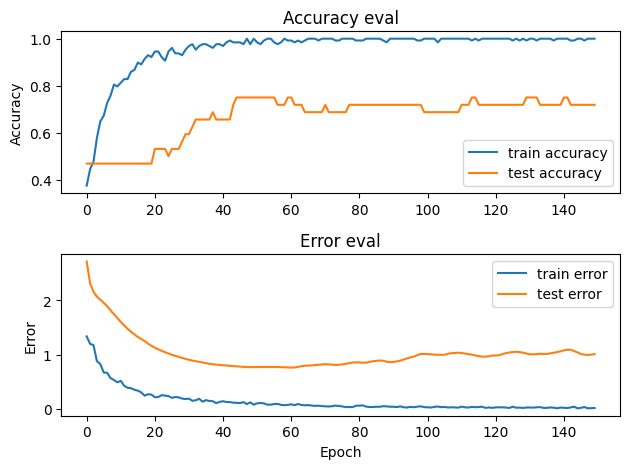

In [59]:
acc_err_plot(cnn_history)

# LSTM

In [60]:
from tensorflow.keras.layers import LSTM

In [142]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

# add an axis to input sets
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [62]:
lstm_model = Sequential([
  LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]),
       return_sequences=True),
  LSTM(64),
  
  Dense(64, activation='relu'),
  Dropout(0.3),
  
  # output
  Dense(3, activation='softmax')
])

In [63]:
lstm_model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              # loss='categorical_crossentropy',
              metrics=['accuracy'])

lstm_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 259, 64)           19968     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_18 (Dense)            (None, 64)                4160      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_19 (Dense)            (None, 3)                 195       
                                                                 
Total params: 57347 (224.01 KB)
Trainable params: 57347 (224.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [64]:
lstm_history = lstm_model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    batch_size=32, epochs=EPOCHS)

Epoch 1/150
4/4 [==============================] - 2s 265ms/step - loss: 1.1330 - accuracy: 0.3281 - val_loss: 1.1890 - val_accuracy: 0.3125
Epoch 2/150
4/4 [==============================] - 0s 92ms/step - loss: 1.1125 - accuracy: 0.3672 - val_loss: 1.1788 - val_accuracy: 0.3125
Epoch 3/150
4/4 [==============================] - 0s 89ms/step - loss: 1.1071 - accuracy: 0.3516 - val_loss: 1.1702 - val_accuracy: 0.3750
Epoch 4/150
4/4 [==============================] - 0s 91ms/step - loss: 1.0889 - accuracy: 0.3984 - val_loss: 1.1602 - val_accuracy: 0.3750
Epoch 5/150
4/4 [==============================] - 0s 93ms/step - loss: 1.0837 - accuracy: 0.3984 - val_loss: 1.1485 - val_accuracy: 0.3750
Epoch 6/150
4/4 [==============================] - 0s 93ms/step - loss: 1.0660 - accuracy: 0.4531 - val_loss: 1.1408 - val_accuracy: 0.3438
Epoch 7/150
4/4 [==============================] - 0s 88ms/step - loss: 1.0484 - accuracy: 0.4766 - val_loss: 1.1323 - val_accuracy: 0.3438
Epoch 8/150
4/4 [==

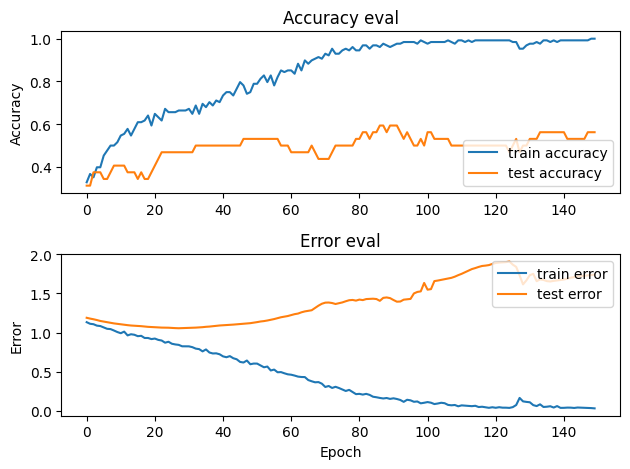

In [65]:
acc_err_plot(lstm_history)

## Prediction

In [66]:
import random

In [67]:
def find_category(value):
  for key, val in category_labelling_map.items():
      if val == value:
          return key
  raise "Error: Not found this value"

In [68]:
def prediction_by_model(model):
  rnd_test_index = random.randint(0, len(X_test))

  x_to_predict = X_test[rnd_test_index]
  y_to_predict = y_test[rnd_test_index]
  
  # add 1 dimension to input data for sample - model.predict() expects a 4d array in this case
  x_to_predict = x_to_predict[np.newaxis, ...]
  
  prediction = model.predict(x_to_predict)
  
  predicted_index = np.argmax(prediction, axis=1)
  
  print(f"Target: {find_category(y_to_predict)}, Predicted label: {find_category(predicted_index)}; test index: {rnd_test_index}")

In [79]:
prediction_by_model(cnn_model)

1/1 [==============================] - 0s 15ms/step
Target: ambulance, Predicted label: ambulance; test index: 31


In [80]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix)

# Performance metrics

In [147]:
y_pred = cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

accuracy_cnn = accuracy_score(y_test, y_pred_classes)
precision_cnn = precision_score(y_test, y_pred_classes, average='weighted')
recall_cnn = recall_score(y_test, y_pred_classes, average='weighted')
f1_cnn = f1_score(y_test, y_pred_classes, average='weighted')
conf_matx_cnn = confusion_matrix(y_test, y_pred_classes)

print(f"Accuracy: {accuracy_cnn}")
print(f"Precision: {precision_cnn}")
print(f"Recall: {recall_cnn}")
print(f"F1 Score: {f1_cnn}")

1/1 [==============================] - 0s 18ms/step
Accuracy: 0.71875
Precision: 0.7542613636363636
Recall: 0.71875
F1 Score: 0.7221840659340659


In [148]:
y_pred = lstm_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

accuracy_lstm = accuracy_score(y_test, y_pred_classes)
precision_lstm = precision_score(y_test, y_pred_classes, average='weighted')
recall_lstm = recall_score(y_test, y_pred_classes, average='weighted')
f1_lstm = f1_score(y_test, y_pred_classes, average='weighted')
conf_matx_lstm = confusion_matrix(y_test, y_pred_classes)

print(f"Accuracy: {accuracy_lstm}")
print(f"Precision: {precision_lstm}")
print(f"Recall: {recall_lstm}")
print(f"F1 Score: {f1_lstm}")

1/1 [==============================] - 0s 48ms/step
Accuracy: 0.5625
Precision: 0.6196428571428572
Recall: 0.5625
F1 Score: 0.5743055555555555


In [150]:
accuracy_svm = accuracy_score(y_test, svm_predictions)
precision_svm = precision_score(y_test, svm_predictions, average='weighted')
recall_svm = recall_score(y_test, svm_predictions, average='weighted')
f1_svm = f1_score(y_test, svm_predictions, average='weighted')

conf_matx_svm = confusion_matrix(y_test, svm_predictions)

print(f"Accuracy: {accuracy_svm}")
print(f"Precision: {precision_svm}")
print(f"Recall: {recall_svm}")
print(f"F1 Score: {f1_svm}")

Accuracy: 0.53125
Precision: 0.5942982456140351
Recall: 0.53125
F1 Score: 0.530241935483871


In [151]:
accuracy_lr = accuracy_score(y_test, lr_predictions)
precision_lr = precision_score(y_test, lr_predictions, average='weighted')
recall_lr = recall_score(y_test, lr_predictions, average='weighted')
f1_lr = f1_score(y_test, lr_predictions, average='weighted')

conf_matx_lr = confusion_matrix(y_test, lr_predictions)

print(f"Accuracy: {accuracy_lr}")
print(f"Precision: {precision_lr}")
print(f"Recall: {recall_lr}")
print(f"F1 Score: {f1_lr}")

Accuracy: 0.65625
Precision: 0.6865530303030303
Recall: 0.65625
F1 Score: 0.6496394230769231


In [152]:
accuracy_dt = accuracy_score(y_test, dt_predictions)
precision_dt = precision_score(y_test, dt_predictions, average='weighted')
recall_dt = recall_score(y_test, dt_predictions, average='weighted')
f1_dt = f1_score(y_test, dt_predictions, average='weighted')

conf_matx_dt = confusion_matrix(y_test, dt_predictions)

print(f"Accuracy: {accuracy_dt}")
print(f"Precision: {precision_dt}")
print(f"Recall: {recall_dt}")
print(f"F1 Score: {f1_dt}")

Accuracy: 0.40625
Precision: 0.41515151515151516
Recall: 0.40625
F1 Score: 0.40377331002331


## Performance metrics graph

In [153]:
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
performance_metrics = {
  'SVM': [accuracy_svm, precision_svm, recall_svm, f1_svm],
  'LR': [accuracy_lr, precision_lr, recall_lr, f1_lr],
  'DT': [accuracy_dt, precision_dt, recall_dt, f1_dt],
  'CNN': [accuracy_cnn, precision_cnn, recall_cnn, f1_cnn],
  'LSTM': [accuracy_lstm, precision_lstm, recall_lstm, f1_lstm],
}

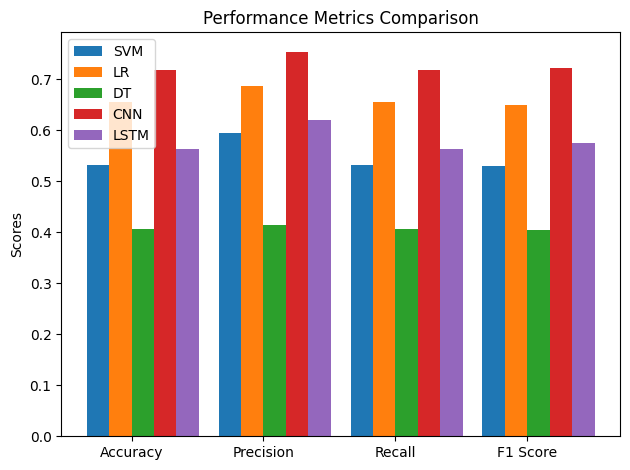

In [139]:
x = np.arange(4)  # total performance metrics
width = 0.17



fig, ax = plt.subplots()
# ax.bar(x - width/2, performance_metrics['CNN'], width, label='CNN')
# ax.bar(x + width/2, performance_metrics['Decision Tree'], width, label='Decision Tree')
# ax.bar(x + width/2, performance_metrics['Decision Tree'], width, label='Decision Tree')
# ax.bar(x + width/2, performance_metrics['Decision Tree'], width, label='Decision Tree')

for i, name in enumerate(["SVM", "LR", "DT", "CNN", "LSTM"]):
    ax.bar(x + width*i, performance_metrics[name], width, label=name)

ax.set_ylabel('Scores')
ax.set_title('Performance Metrics Comparison')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

ax.set_ylabel('Scores')
ax.set_title('Performance Metrics Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

# Confusion matrix

In [155]:
import seaborn as sns

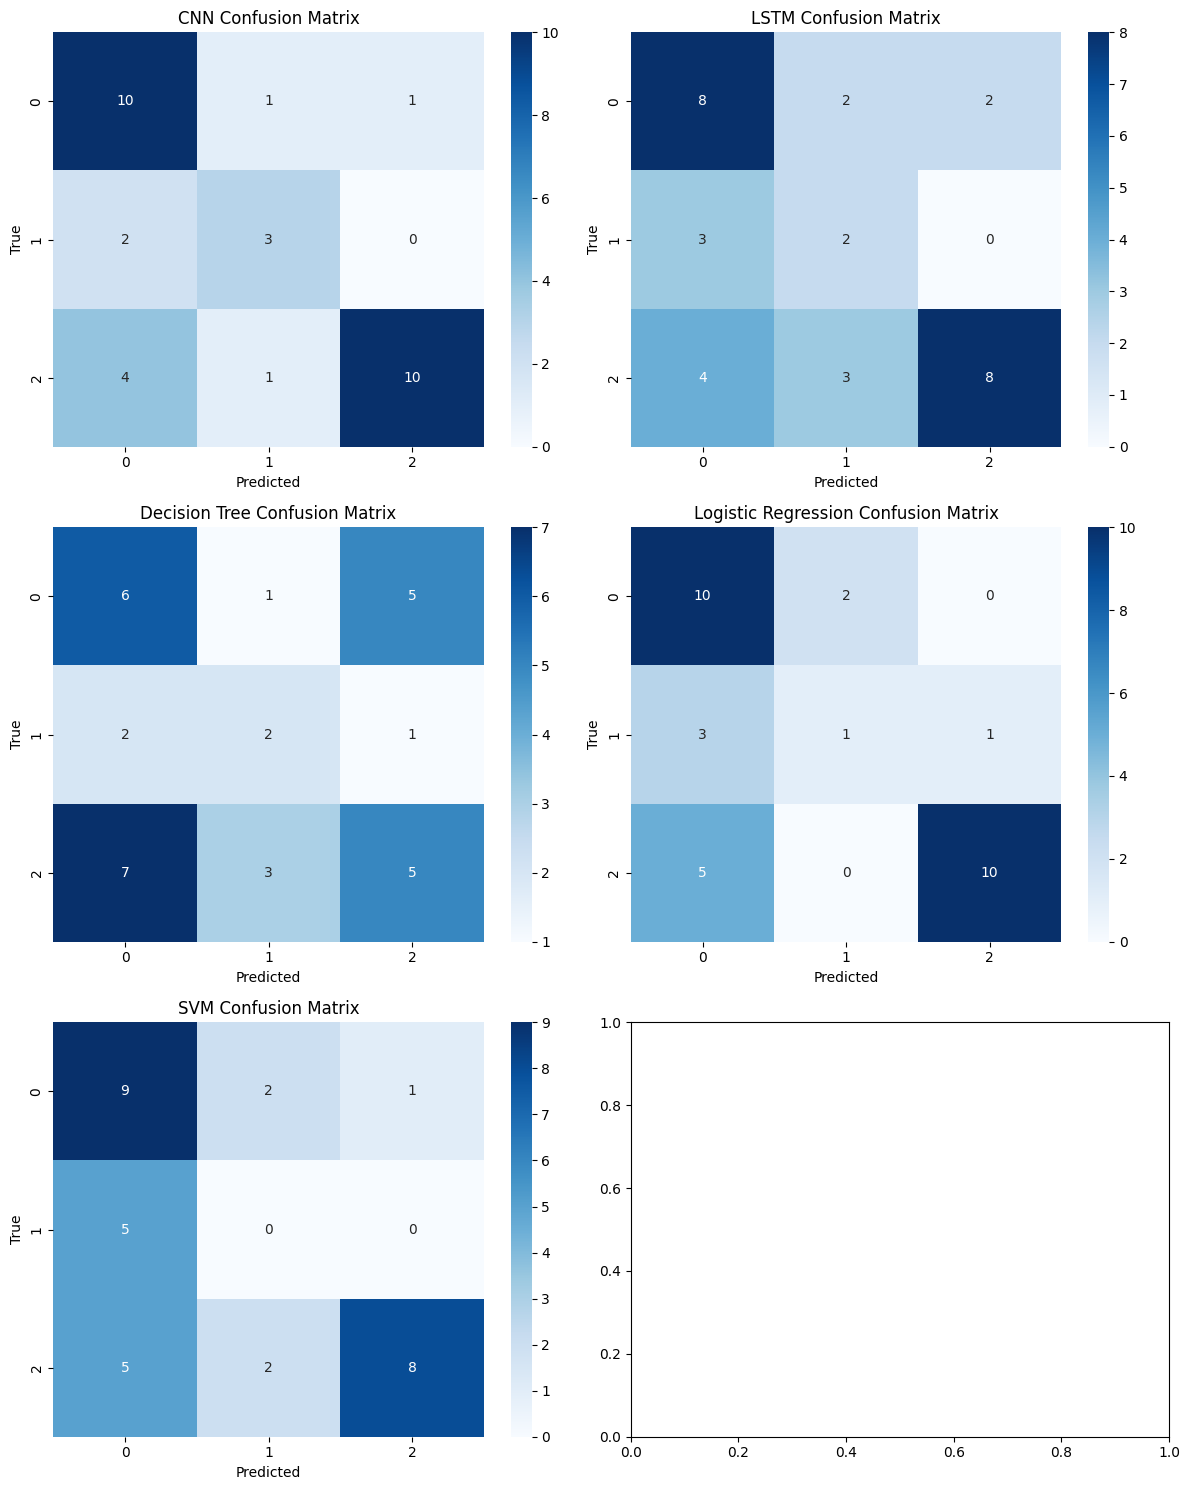

In [160]:
fig, axes = plt.subplots(3, 2, figsize=(12, 15))

# CNN Confusion Matrix
sns.heatmap(conf_matx_cnn, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
# axes[0 0].imshow(conf_matx_cnn, interpolation='nearest', cmap=plt.cm.Blues)
axes[0,0].set_title('CNN Confusion Matrix')
axes[0,0].set_xlabel('Predicted')
axes[0,0].set_ylabel('True')

# LSTM Confusion Matrix
sns.heatmap(conf_matx_lstm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1])
# axes[0 1].imshow(conf_matx_lstm, interpolation='nearest', cmap=plt.cm.Blues)
axes[0,1].set_title('LSTM Confusion Matrix')
axes[0,1].set_xlabel('Predicted')
axes[0,1].set_ylabel('True')

# Decision Tree Confusion Matrix
sns.heatmap(conf_matx_dt, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0])
# axes[1,0].imshow(conf_matx_dt, interpolation='nearest', cmap=plt.cm.Blues)
axes[1,0].set_title('Decision Tree Confusion Matrix')
axes[1,0].set_xlabel('Predicted')
axes[1,0].set_ylabel('True')

# Logistic Regression Confusion Matrix
sns.heatmap(conf_matx_lr, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1])
# axes[1,1].imshow(conf_matx_lr, interpolation='nearest', cmap=plt.cm.Blues)
axes[1,1].set_title('Logistic Regression Confusion Matrix')
axes[1,1].set_xlabel('Predicted')
axes[1,1].set_ylabel('True')

# Logistic Regression Confusion Matrix
sns.heatmap(conf_matx_svm, annot=True, fmt='d', cmap='Blues', ax=axes[2, 0])
# axes[1,1].imshow(conf_matx_lr, interpolation='nearest', cmap=plt.cm.Blues)
axes[2,0].set_title('SVM Confusion Matrix')
axes[2,0].set_xlabel('Predicted')
axes[2,0].set_ylabel('True')

plt.tight_layout()
plt.show()